# KE5018 Time Series Forecasting

## Load Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Load Data

In [2]:
train_ts_df = pd.read_csv('data/transformedTrainRatings.csv', index_col=0, parse_dates=True)
train_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,1.683670
2007-06-24,1,24-Jun-2007 (26),263.19,1.687012
2007-07-01,2,01-Jul-2007 (27),269.89,1.688067
2007-07-08,3,08-Jul-2007 (28),252.88,1.685303
2007-07-15,4,15-Jul-2007 (29),303.46,1.692792


In [3]:
test_ts_df = pd.read_csv('data/transformedTestRatings.csv', index_col=0, parse_dates=True)
test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,
2008-06-22,53,22-Jun-2008 (26),214.32,1.677804
2008-06-29,54,29-Jun-2008 (27),233.76,1.681827
2008-07-06,55,06-Jul-2008 (28),231.12,1.681312
2008-07-13,56,13-Jul-2008 (29),224.72,1.680024
2008-07-20,57,20-Jul-2008 (30),216.19,1.678215


## Holt's Trend Corrected Two Parameter Exponential Smoothing

In [4]:
# For storing model results
results_list = []

### Use StatsModels to find the optimal weights for alpha and beta

In [5]:
# smoothing level = alpha (level), smoothing slope = beta (growth rate)
# The model will automatically optimize the value.
holt_train = sm.tsa.Holt(train_ts_df['GRP_boxcox'].values, exponential=True, damped=True).fit(optimized=True)
holt_train

In [6]:
holt_train.params

{'damping_slope': 0.73686872110623369,
 'initial_level': 1.6809836754829508,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': 1.0017555749063303,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.57894236947940891,
 'smoothing_seasonal': nan,
 'smoothing_slope': 0.0,
 'use_boxcox': False}

### Manually Adjust Apha and Beta 

In [7]:
train_ts_df.tail()

,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,
2008-05-18,48,18-May-2008 (21),227.32,1.680554
2008-05-25,49,25-May-2008 (22),218.16,1.678643
2008-06-01,50,01-Jun-2008 (23),228.92,1.680876
2008-06-08,51,08-Jun-2008 (24),231.79,1.681444
2008-06-15,52,15-Jun-2008 (25),231.19,1.681326


In [8]:
holt_test = sm.tsa.Holt(test_ts_df['GRP_boxcox'].values,
                        exponential=True,
                        damped=True).fit(smoothing_level=holt_train.params['smoothing_level'],
                                         smoothing_slope=holt_train.params['smoothing_slope'],
                                         damping_slope=holt_train.params['damping_slope'],
                                         optimized=False)
holt_test

In [9]:
holt_test.params

{'damping_slope': 0.73686872110623369,
 'initial_level': 1.6778035283761736,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': 1.0017665543450414,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.57894236947940891,
 'smoothing_seasonal': None,
 'smoothing_slope': 0.0,
 'use_boxcox': False}

In [10]:
BOXCOX_LAMBDA = -0.5677106

train_ts_df['holt'] = inv_boxcox(holt_train.predict(0, len(train_ts_df)-1), BOXCOX_LAMBDA)
train_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,holt
weekly_date,,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,1.683670,240.802270
2007-06-24,1,24-Jun-2007 (26),263.19,1.687012,251.452391
2007-07-01,2,01-Jul-2007 (27),269.89,1.688067,265.454707
2007-07-08,3,08-Jul-2007 (28),252.88,1.685303,273.694497
2007-07-15,4,15-Jul-2007 (29),303.46,1.692792,265.337363


In [11]:
test_ts_df['holt'] = inv_boxcox(holt_test.predict(start=0, end=len(test_ts_df)-1), BOXCOX_LAMBDA)
test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,holt
weekly_date,,,,,
2008-06-22,53,22-Jun-2008 (26),214.32,1.677804,224.540560
2008-06-29,54,29-Jun-2008 (27),233.76,1.681827,226.227397
2008-07-06,55,06-Jul-2008 (28),231.12,1.681312,236.675051
2008-07-13,56,13-Jul-2008 (29),224.72,1.680024,238.019513
2008-07-20,57,20-Jul-2008 (30),216.19,1.678215,233.464521


In [12]:
test_ts_df['holt-outofsample'] = inv_boxcox(holt_train.predict(start=len(train_ts_df), end=len(train_ts_df) + len(test_ts_df)-1), BOXCOX_LAMBDA)
test_ts_df.tail()

,week,GRPRatingsDate,GRP,GRP_boxcox,holt,holt-outofsample
weekly_date,,,,,,
2009-02-15,87,15-Feb-2009 (8),204.20,1.675474,205.050500,230.305286
2009-02-22,88,22-Feb-2009 (9),200.61,1.674604,204.557643,230.305286
2009-03-01,89,01-Mar-2009 (10),208.56,1.676500,202.257653,230.305286
2009-03-08,90,08-Mar-2009 (11),191.74,1.672345,205.869450,230.305286
2009-03-15,91,15-Mar-2009 (12),222.07,1.679474,197.498236,230.305286


In [13]:
holt_train_mse = mean_squared_error(train_ts_df['GRP'].values, train_ts_df['holt'].values)
holt_train_rmse = np.sqrt(holt_train_mse)
holt_train_mape = np.sum(np.abs(train_ts_df['GRP'].values - train_ts_df['holt'].values) / train_ts_df['GRP'].values) / len(train_ts_df['GRP'].values) * 100
holt_test_mse = mean_squared_error(test_ts_df['GRP'].values, test_ts_df['holt'].values)
holt_test_rmse = np.sqrt(holt_test_mse)
holt_test_mape = np.sum(np.abs(test_ts_df['GRP'].values - test_ts_df['holt'].values) / test_ts_df['GRP'].values) / len(test_ts_df['GRP'].values) * 100

results_list.append([holt_train_mse, holt_train_rmse, holt_train_mape, holt_test_mse, holt_test_rmse, holt_test_mape])

results_df = pd.DataFrame(results_list,
                          index=["Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised)"],
                          columns=['train mse', 'train rmse', 'train mape', 'test mse', 'test rmse', 'test mape'])
results_df

,train mse,train rmse,train mape,test mse,test rmse,test mape
Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised),340.686547,18.457696,4.818447,232.578893,15.250537,5.841904


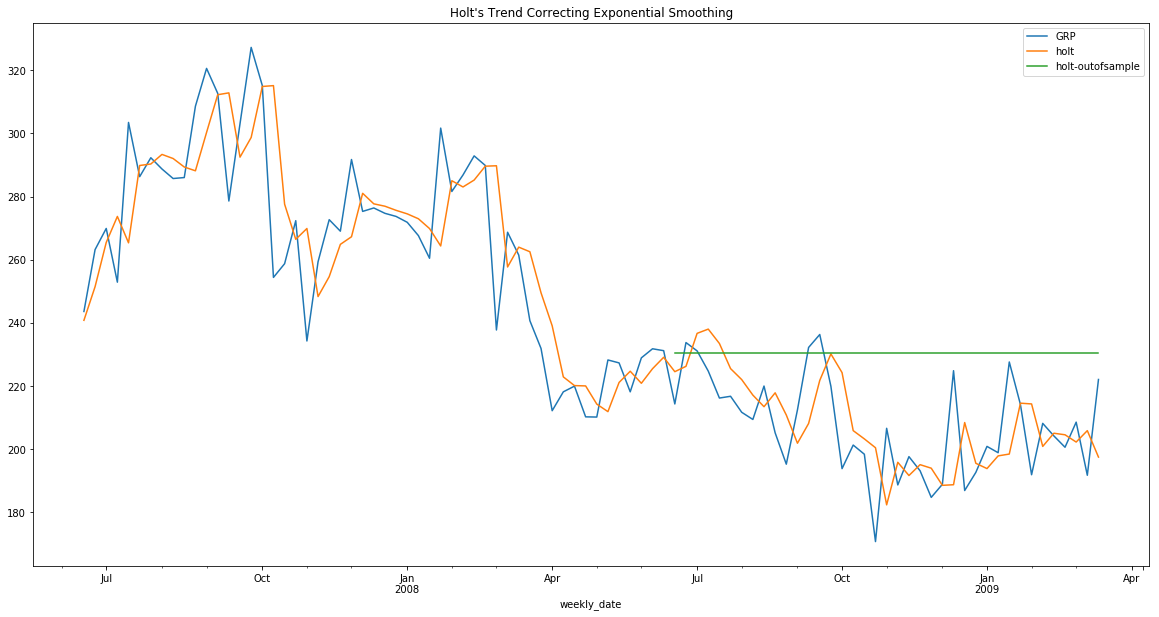

In [14]:
new_ts_df = train_ts_df.append(test_ts_df)
new_ts_df[['GRP', 'holt', 'holt-outofsample']].plot(figsize=(20, 10), title="Holt's Trend Correcting Exponential Smoothing")

In [15]:
residuals = train_ts_df['GRP'].values - train_ts_df['holt']
residuals[:10]

weekly_date
2007-06-17     2.797730
2007-06-24    11.737609
2007-07-01     4.435293
2007-07-08   -20.814497
2007-07-15    38.122637
2007-07-22    -3.540566
2007-07-29     1.984460
2007-08-05    -4.615480
2007-08-12    -6.336843
2007-08-19    -3.340096
Name: holt, dtype: float64

In [16]:
holt_res = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=3)),
        ('linear', LinearRegression(fit_intercept=False))])
holt_res.fit(train_ts_df['week'].values.reshape(-1, 1), residuals)
holt_res_pred = holt_res.predict(train_ts_df['week'].values.reshape(-1, 1))

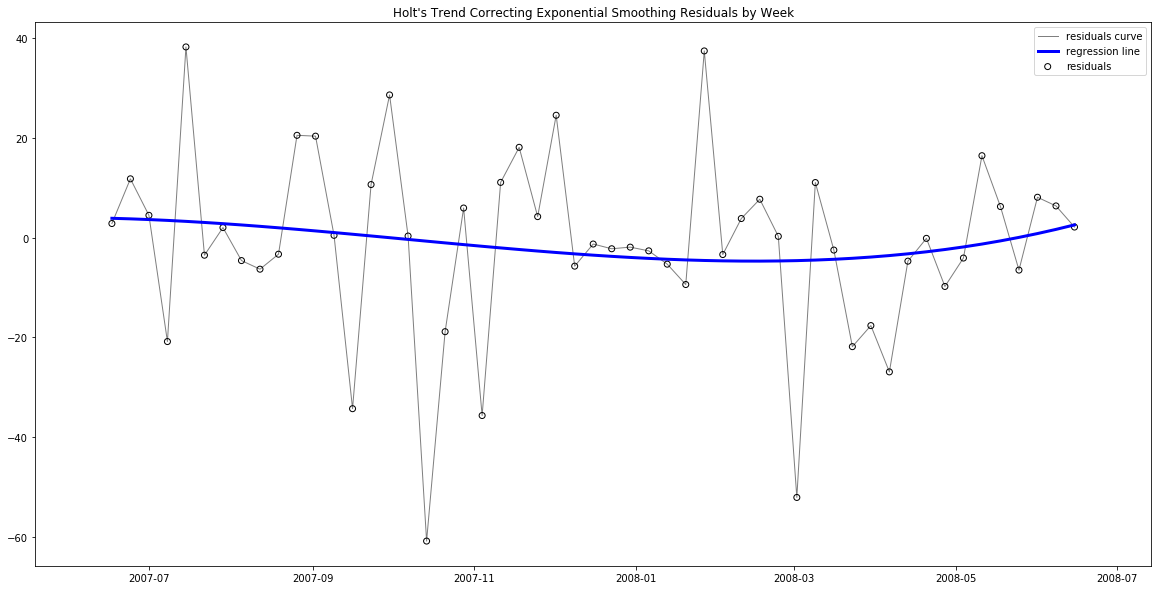

In [17]:
plt.figure(figsize=(20, 10))
plt.title("Holt's Trend Correcting Exponential Smoothing Residuals by Week")
plt.scatter(train_ts_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(train_ts_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(train_ts_df.index.values, holt_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

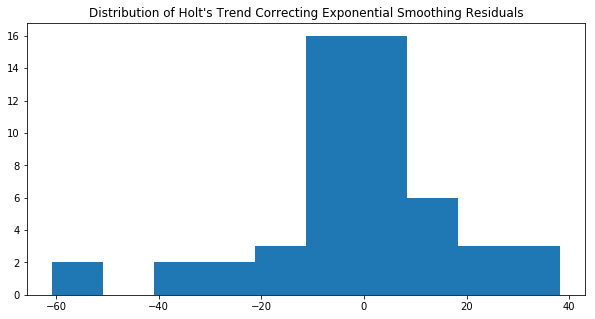

In [18]:
plt.figure(figsize=(10, 5))
plt.title("Distribution of Holt's Trend Correcting Exponential Smoothing Residuals")
plt.hist(residuals)
plt.show()

In [19]:
lb = acorr_ljungbox(residuals, lags=10)
lb_df = pd.DataFrame({'Lag':range(1, len(lb[0])+1), 'Ljung-Box_Stat':lb[0], 'P-value':lb[1]})
lb_df

,Lag,Ljung-Box_Stat,P-value
0,1,0.000463,0.982837
1,2,2.073317,0.354638
2,3,2.655965,0.447762
3,4,3.264981,0.514500
4,5,3.909851,0.562467
5,6,4.251005,0.642750
6,7,5.385400,0.613040
7,8,5.387825,0.715434
8,9,5.696000,0.769916
9,10,5.702614,0.839599


/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


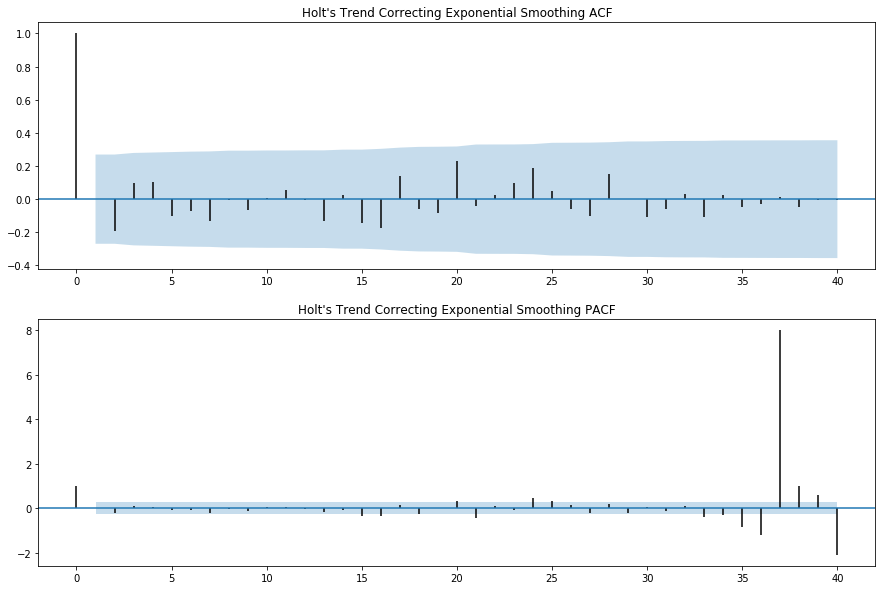

In [20]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, lags=40, title="Holt's Trend Correcting Exponential Smoothing ACF", marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, lags=40, title="Holt's Trend Correcting Exponential Smoothing PACF", marker=None)
plt.show()

The residuals are close to gaussian distribution and show no autocorrelation. The model fits well.

### Manually Adjust Apha and Beta 

In [21]:
# smoothing level = alpha (level), smoothing slope = beta (growth rate)
holt1_train = sm.tsa.Holt(train_ts_df['GRP_boxcox'].values, exponential=True, damped=False).fit(smoothing_level=.8, smoothing_slope=.1, damping_slope=.1, optimized=False)
holt1_train

In [22]:
holt1_train.params

{'damping_slope': nan,
 'initial_level': 1.6836695615279251,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': 1.0019849683556756,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.8,
 'smoothing_seasonal': None,
 'smoothing_slope': 0.1,
 'use_boxcox': False}

In [23]:
train_ts_df['holt1'] = inv_boxcox(holt1_train.predict(0, len(train_ts_df)-1), BOXCOX_LAMBDA)
train_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,holt,holt1
weekly_date,,,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,1.683670,240.802270,263.190000
2007-06-24,1,24-Jun-2007 (26),263.19,1.687012,251.452391,265.713733
2007-07-01,2,01-Jul-2007 (27),269.89,1.688067,265.454707,283.868786
2007-07-08,3,08-Jul-2007 (28),252.88,1.685303,273.694497,292.671010
2007-07-15,4,15-Jul-2007 (29),303.46,1.692792,265.337363,275.462913


In [24]:
train_ts_df.tail()

,week,GRPRatingsDate,GRP,GRP_boxcox,holt,holt1
weekly_date,,,,,,
2008-05-18,48,18-May-2008 (21),227.32,1.680554,221.125697,221.983184
2008-05-25,49,25-May-2008 (22),218.16,1.678643,224.679095,224.970074
2008-06-01,50,01-Jun-2008 (23),228.92,1.680876,220.868301,217.758072
2008-06-08,51,08-Jun-2008 (24),231.79,1.681444,225.474577,225.694520
2008-06-15,52,15-Jun-2008 (25),231.19,1.681326,229.097458,230.094037


In [25]:
holt1_test = sm.tsa.Holt(test_ts_df['GRP_boxcox'].values,
                        exponential=True,
                        damped=False).fit(smoothing_level=holt1_train.params['smoothing_level'],
                                         smoothing_slope=holt1_train.params['smoothing_slope'],
                                         damping_slope=holt1_train.params['damping_slope'],
                                         optimized=False)
holt1_test

In [26]:
holt1_test.params

{'damping_slope': nan,
 'initial_level': 1.6778035283761736,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': 1.0023981358925296,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.8,
 'smoothing_seasonal': None,
 'smoothing_slope': 0.1,
 'use_boxcox': False}

In [27]:
test_ts_df['holt1'] = inv_boxcox(holt1_test.predict(start=0, end=len(test_ts_df)-1), BOXCOX_LAMBDA)
test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,holt,holt-outofsample,holt1
weekly_date,,,,,,,
2008-06-22,53,22-Jun-2008 (26),214.32,1.677804,224.540560,230.305283,233.760000
2008-06-29,54,29-Jun-2008 (27),233.76,1.681827,226.227397,230.305284,236.286958
2008-07-06,55,06-Jul-2008 (28),231.12,1.681312,236.675051,230.305284,254.601127
2008-07-13,56,13-Jul-2008 (29),224.72,1.680024,238.019513,230.305285,254.025831
2008-07-20,57,20-Jul-2008 (30),216.19,1.678215,233.464521,230.305285,245.482823


In [28]:
test_ts_df['holt1-outofsample'] = inv_boxcox(holt1_train.predict(start=len(train_ts_df), end=len(train_ts_df) + len(test_ts_df)-1), BOXCOX_LAMBDA)
test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,holt,holt-outofsample,holt1,holt1-outofsample
weekly_date,,,,,,,,
2008-06-22,53,22-Jun-2008 (26),214.32,1.677804,224.540560,230.305283,233.760000,230.600081
2008-06-29,54,29-Jun-2008 (27),233.76,1.681827,226.227397,230.305284,236.286958,230.230953
2008-07-06,55,06-Jul-2008 (28),231.12,1.681312,236.675051,230.305284,254.601127,229.862767
2008-07-13,56,13-Jul-2008 (29),224.72,1.680024,238.019513,230.305285,254.025831,229.495519
2008-07-20,57,20-Jul-2008 (30),216.19,1.678215,233.464521,230.305285,245.482823,229.129205


In [29]:
holt1_train_mse = mean_squared_error(train_ts_df['GRP'].values, train_ts_df['holt1'].values)
holt1_train_rmse = np.sqrt(holt_train_mse)
holt1_train_mape = np.sum(np.abs(train_ts_df['GRP'].values - train_ts_df['holt1'].values) / train_ts_df['GRP'].values) / len(train_ts_df['GRP'].values) * 100
holt1_test_mse = mean_squared_error(test_ts_df['GRP'].values, test_ts_df['holt1'].values)
holt1_test_rmse = np.sqrt(holt1_test_mse)
holt1_test_mape = np.sum(np.abs(test_ts_df['GRP'].values - test_ts_df['holt1'].values) / test_ts_df['GRP'].values) / len(test_ts_df['GRP'].values) * 100

results_list.append([holt1_train_mse, holt1_train_rmse, holt1_train_mape, holt1_test_mse, holt1_test_rmse, holt1_test_mape])

In [30]:
results_df = pd.DataFrame(results_list,
                          index=["Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised)",
                                 "Holt's Trend Corrected Exponential Smoothing (Manually Adjusted)"],
                          columns=['train mse', 'train rmse', 'train mape', 'test mse', 'test rmse', 'test mape'])
results_df

,train mse,train rmse,train mape,test mse,test rmse,test mape
Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised),340.686547,18.457696,4.818447,232.578893,15.250537,5.841904
Holt's Trend Corrected Exponential Smoothing (Manually Adjusted),473.335043,18.457696,6.023439,360.959937,18.998946,7.403487


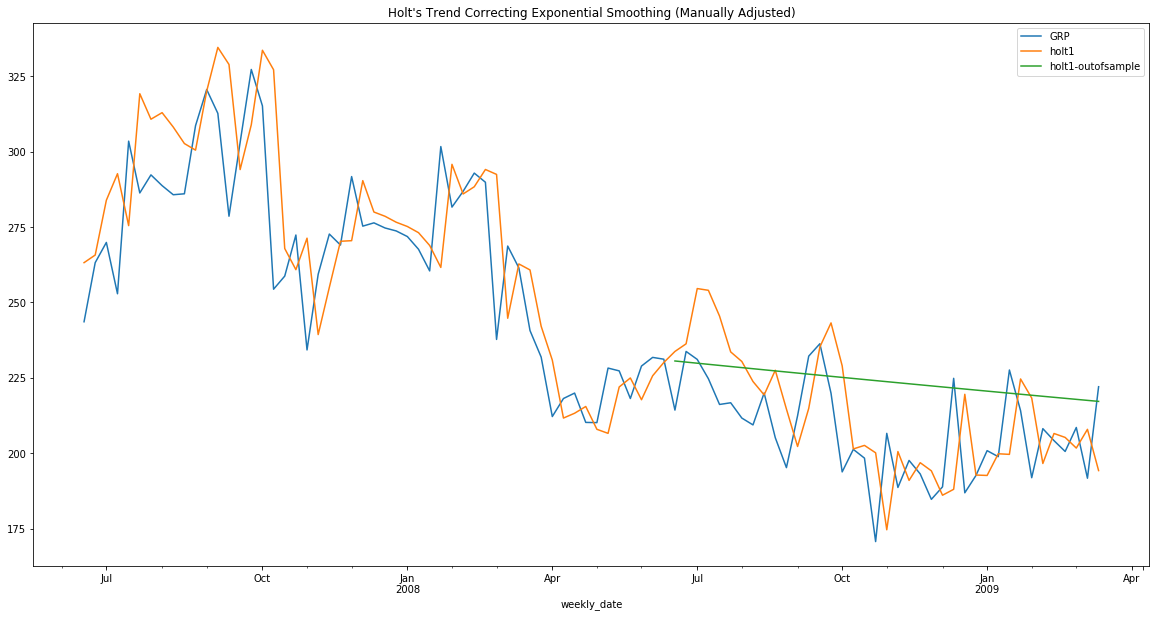

In [31]:
new_ts_df = train_ts_df.append(test_ts_df)
new_ts_df[['GRP', 'holt1', 'holt1-outofsample']].plot(figsize=(20, 10), title="Holt's Trend Correcting Exponential Smoothing (Manually Adjusted)")

## Additive Holt-Winters Method (three parameters)

### Reload the Data

In [32]:
# This is the seasonal period used in the model
FREQ = 20

train_ts_df = pd.read_csv('data/transformedTrainRatings.csv', index_col=0, parse_dates=True)
test_ts_df = pd.read_csv('data/transformedTestRatings.csv', index_col=0, parse_dates=True)

We use the same 5 month (5 x 4 = 20 periods) season from the dummy variable linear regression and decomposition method.

In [33]:
# *** Using multiplicative and damped=True produces errors. ***
hw_train = sm.tsa.ExponentialSmoothing(train_ts_df['GRP_boxcox'], trend="additive", damped=False, seasonal="additive", seasonal_periods=FREQ).fit(optimized=True)
hw_train

/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


In [34]:
hw_train.params

{'damping_slope': nan,
 'initial_level': 1.6812697097702978,
 'initial_seasons': array([ 0.00291752,  0.00515246,  0.00501725,  0.00454663,  0.00847206,
         0.00640878,  0.00693557,  0.0081815 ,  0.0081348 ,  0.00762438,
         0.00935949,  0.00986013,  0.01171649,  0.00851929,  0.01080215,
         0.01291871,  0.01224077,  0.00394168,  0.00719291,  0.00794161]),
 'initial_slope': 0.0,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.71355576167999035,
 'smoothing_seasonal': 0.0,
 'smoothing_slope': 0.024935840010123431,
 'use_boxcox': False}

In [35]:
train_ts_df['hw'] = inv_boxcox(hw_train.predict(0, len(train_ts_df)-1), BOXCOX_LAMBDA)
train_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,hw
weekly_date,,,,,
2007-06-17,0,17-Jun-2007 (25),243.60,1.683670,246.481877
2007-06-24,1,24-Jun-2007 (26),263.19,1.687012,257.268570
2007-07-01,2,01-Jul-2007 (27),269.89,1.688067,260.690085
2007-07-08,3,08-Jul-2007 (28),252.88,1.685303,264.441639
2007-07-15,4,15-Jul-2007 (29),303.46,1.692792,281.325805


In [36]:
train_ts_df.tail()

,week,GRPRatingsDate,GRP,GRP_boxcox,hw
weekly_date,,,,,
2008-05-18,48,18-May-2008 (21),227.32,1.680554,223.200635
2008-05-25,49,25-May-2008 (22),218.16,1.678643,222.738382
2008-06-01,50,01-Jun-2008 (23),228.92,1.680876,226.807045
2008-06-08,51,08-Jun-2008 (24),231.79,1.681444,229.827246
2008-06-15,52,15-Jun-2008 (25),231.19,1.681326,239.938689


In [37]:
# Add the last train observation to test dataset to make it 40 observations. Less than this fitting the exponential smoothing breaks.
cols = test_ts_df.columns.tolist()
a_test_ts_df = pd.concat([train_ts_df[len(train_ts_df) - 1:], test_ts_df])
a_test_ts_df = a_test_ts_df[cols]
a_test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox
weekly_date,,,,
2008-06-15,52,15-Jun-2008 (25),231.19,1.681326
2008-06-22,53,22-Jun-2008 (26),214.32,1.677804
2008-06-29,54,29-Jun-2008 (27),233.76,1.681827
2008-07-06,55,06-Jul-2008 (28),231.12,1.681312
2008-07-13,56,13-Jul-2008 (29),224.72,1.680024


In [38]:
hw_test = sm.tsa.ExponentialSmoothing(a_test_ts_df['GRP_boxcox'], trend="additive", damped=False,
                                      seasonal="additive", seasonal_periods=FREQ).fit(
    smoothing_level=hw_train.params['smoothing_level'],
    smoothing_slope=hw_train.params['smoothing_slope'],
    smoothing_seasonal=hw_train.params['smoothing_seasonal'],
    damping_slope=hw_train.params['damping_slope'],
    optimized=False)
a_test_ts_df['hw'] = inv_boxcox(hw_test.predict(0, len(a_test_ts_df) - 1), BOXCOX_LAMBDA)
a_test_ts_df.head()


/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


,week,GRPRatingsDate,GRP,GRP_boxcox,hw
weekly_date,,,,,
2008-06-15,52,15-Jun-2008 (25),231.19,1.681326,230.496493
2008-06-22,53,22-Jun-2008 (26),214.32,1.677804,213.539118
2008-06-29,54,29-Jun-2008 (27),233.76,1.681827,232.827156
2008-07-06,55,06-Jul-2008 (28),231.12,1.681312,230.209100
2008-07-13,56,13-Jul-2008 (29),224.72,1.680024,223.865261


In [39]:
a_test_ts_df['hw-outofsample'] = inv_boxcox(hw_train.predict(start=len(train_ts_df)-1, end=len(train_ts_df) + len(a_test_ts_df)-2), BOXCOX_LAMBDA)
a_test_ts_df.head()

,week,GRPRatingsDate,GRP,GRP_boxcox,hw,hw-outofsample
weekly_date,,,,,,
2008-06-15,52,15-Jun-2008 (25),231.19,1.681326,230.496493,239.938689
2008-06-22,53,22-Jun-2008 (26),214.32,1.677804,213.539118,216.976824
2008-06-29,54,29-Jun-2008 (27),233.76,1.681827,232.827156,226.798693
2008-07-06,55,06-Jul-2008 (28),231.12,1.681312,230.209100,236.457863
2008-07-13,56,13-Jul-2008 (29),224.72,1.680024,223.865261,231.798978


In [40]:
hw_train_mse = mean_squared_error(train_ts_df['GRP'].values, train_ts_df['hw'].values)
hw_train_rmse = np.sqrt(hw_train_mse)
hw_train_mape = np.sum(np.abs(train_ts_df['GRP'].values - train_ts_df['hw'].values) / train_ts_df['GRP'].values) / len(train_ts_df['GRP'].values) * 100
hw_test_mse = mean_squared_error(a_test_ts_df['GRP'].values, a_test_ts_df['hw'].values)
hw_test_rmse = np.sqrt(hw_test_mse)
hw_test_mape = np.nansum(np.abs(a_test_ts_df['GRP'].values - a_test_ts_df['hw'].values) / a_test_ts_df['GRP'].values) / len(a_test_ts_df['GRP'].values) * 100

results_list.append([hw_train_mse, hw_train_rmse, hw_train_mape, hw_test_mse, hw_test_rmse, hw_test_mape])

In [41]:
results_df = pd.DataFrame(results_list,
                          index=["Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised)",
                                 "Holt's Trend Corrected Exponential Smoothing (Manually Adjusted)",
                                 "Additive Holt's & Winter's Method"],
                          columns=['train mse', 'train rmse', 'train mape', 'test mse', 'test rmse', 'test mape'])
results_df

,train mse,train rmse,train mape,test mse,test rmse,test mape
Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised),340.686547,18.457696,4.818447,232.578893,15.250537,5.841904
Holt's Trend Corrected Exponential Smoothing (Manually Adjusted),473.335043,18.457696,6.023439,360.959937,18.998946,7.403487
Additive Holt's & Winter's Method,116.870267,10.810655,3.272525,281.852366,16.788459,4.424103


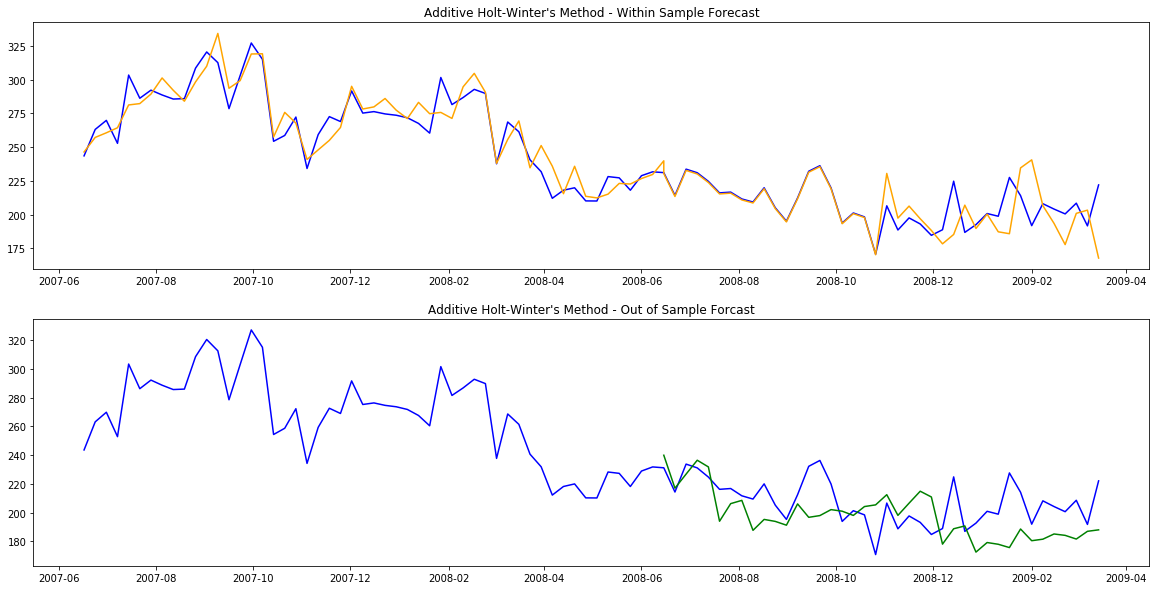

In [42]:
new_ts_df = train_ts_df.append(a_test_ts_df)

plt.figure(figsize=(20, 10))
plt.subplot(211)
plt.plot(new_ts_df['GRP'], color='blue')
plt.plot(new_ts_df['hw'], color='orange')
plt.title("Additive Holt-Winter's Method - Within Sample Forecast")
plt.subplot(212)
plt.plot(new_ts_df['GRP'], color='blue')
plt.plot(new_ts_df['hw-outofsample'], color='green')
plt.title("Additive Holt-Winter's Method - Out of Sample Forcast")
plt.show()

In [43]:
residuals = train_ts_df['GRP'].values - train_ts_df['hw']
residuals[:10]

weekly_date
2007-06-17    -2.881877
2007-06-24     5.921430
2007-07-01     9.199915
2007-07-08   -11.561639
2007-07-15    22.134195
2007-07-22     3.971999
2007-07-29     2.918859
2007-08-05   -12.595296
2007-08-12    -6.498866
2007-08-19     1.913472
Name: hw, dtype: float64

In [44]:
hw_res = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=3)),
        ('linear', LinearRegression(fit_intercept=False))])
hw_res.fit(train_ts_df['week'].values.reshape(-1, 1), residuals)
hw_res_pred = hw_res.predict(train_ts_df['week'].values.reshape(-1, 1))

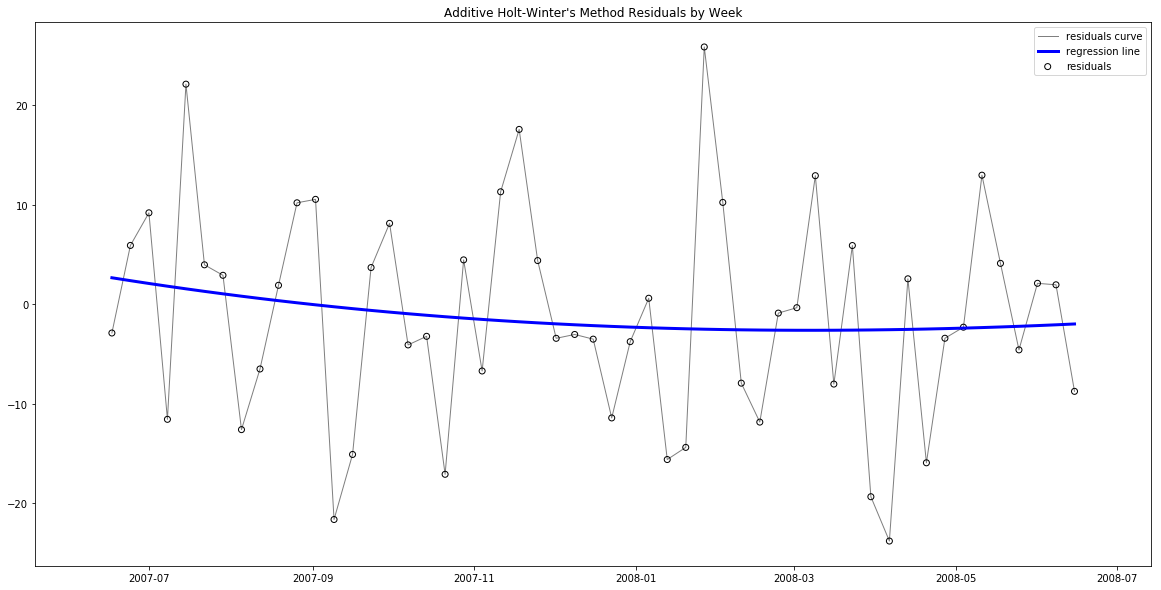

In [45]:

plt.figure(figsize=(20, 10))
plt.title("Additive Holt-Winter's Method Residuals by Week")
plt.scatter(train_ts_df.index.values, residuals, color='black', marker='o', label='residuals', facecolors='none')
plt.plot(train_ts_df.index.values, residuals, color='black', linewidth=1, label='residuals curve', alpha=.5)
plt.plot(train_ts_df.index.values, hw_res_pred, color='blue', linewidth=3, label='regression line')
plt.legend()
plt.show()

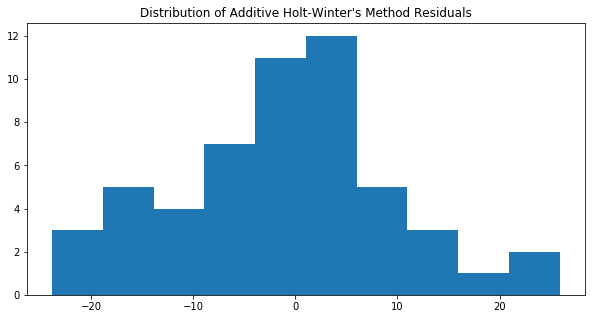

In [46]:
plt.figure(figsize=(10, 5))
plt.title("Distribution of Additive Holt-Winter's Method Residuals")
plt.hist(residuals)
plt.show()

In [47]:
lb = acorr_ljungbox(residuals, lags=10)
lb_df = pd.DataFrame({'Lag':range(1, len(lb[0])+1), 'Ljung-Box_Stat':lb[0], 'P-value':lb[1]})
lb_df

,Lag,Ljung-Box_Stat,P-value
0,1,0.256505,0.612532
1,2,2.106799,0.348750
2,3,4.020451,0.259264
3,4,4.078503,0.395486
4,5,4.125298,0.531521
5,6,4.126244,0.659597
6,7,4.126269,0.765124
7,8,5.522158,0.700584
8,9,7.673507,0.567354
9,10,7.887022,0.639872


/home/tkokkeng/Documents/KE5108/TimeSeries/venv/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


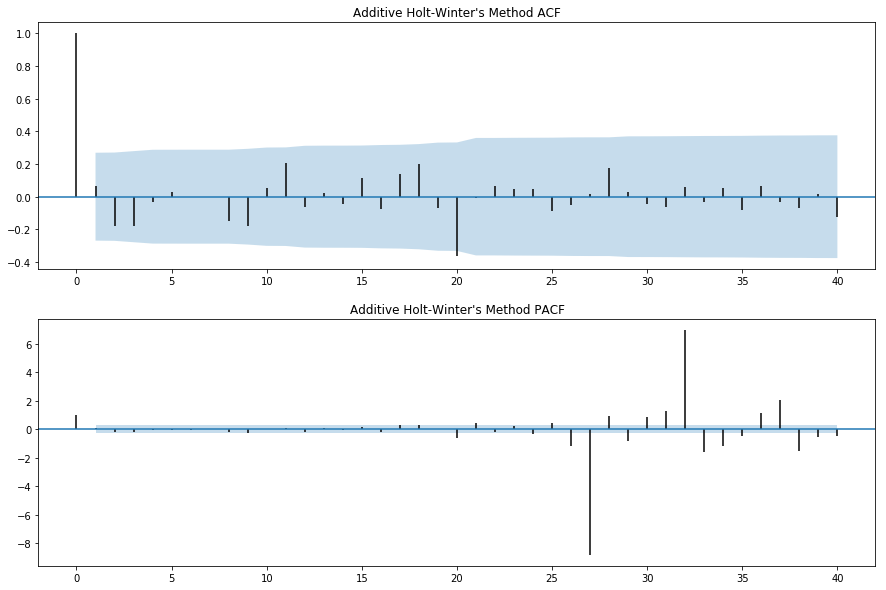

In [48]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(211)
acf = plot_acf(residuals, ax, lags=40, title="Additive Holt-Winter's Method ACF", marker=None)
ax = plt.subplot(212)
pacf = plot_pacf(residuals, ax, lags=40, title="Additive Holt-Winter's Method PACF", marker=None)
plt.show()

## Conclusion

In [49]:
results_df = pd.DataFrame(results_list,
                          index=["Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised)",
                                 "Holt's Trend Corrected Exponential Smoothing (Manually Adjusted)",
                                 "Additive Holt's & Winter's Method"
                                 ],
                          columns=['train mse', 'train rmse', 'train mape', 'test mse', 'test rmse', 'test mape'])
results_df

,train mse,train rmse,train mape,test mse,test rmse,test mape
Holt's Trend Corrected Exponential Smoothing (StatsModels Optimised),340.686547,18.457696,4.818447,232.578893,15.250537,5.841904
Holt's Trend Corrected Exponential Smoothing (Manually Adjusted),473.335043,18.457696,6.023439,360.959937,18.998946,7.403487
Additive Holt's & Winter's Method,116.870267,10.810655,3.272525,281.852366,16.788459,4.424103
